In [47]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
from collections import Counter
import random
import statsmodels.api as sm
from scipy import optimize
%matplotlib inline

import matplotlib.font_manager as font_manager
path = '/Users/zhicongchen/msyh.ttf'
fontprop = font_manager.FontProperties(fname=path)

In [2]:
df = pd.read_csv('./attentionflow/20161220_attention.csv')

In [3]:
user_sum = float(df['uid'].nunique())

In [4]:
book_groups = df.groupby('book_id')['uid'].groups

In [18]:
book_groups['55ec4d264c5d2c074185155997625bcd']
# return is the index of df

[19504]

In [19]:
df[df['book_id'] == '55ec4d264c5d2c074185155997625bcd']

,uid,book_id,duration,startingtime
19504,1088179308,55ec4d264c5d2c074185155997625bcd,656059,2016-12-20 00:00:01


In [8]:
df['uid'].iloc[book_groups['55ec4d264c5d2c074185155997625bcd']]

19504    1088179308
Name: uid, dtype: int64

# build network
建立流网络时在每个节点上记录一个list，对流网络中的edge，看这两个节点（书）读的人的list，找overlap的人数

In [22]:
def constructFlowNetwork (C):
    E=defaultdict(lambda:0)
    E[('source',C[0][1])]+=1
    E[(C[-1][1],'sink')]+=1
    F=zip(C[:-1],C[1:])
    for i in F:
        if i[0][0]==i[1][0]:
            E[(i[0][1],i[1][1])]+=1
        else:
            E[(i[0][1],'sink')]+=1
            E[('source',i[1][1])]+=1
    G=nx.DiGraph()
    for i,j in E.items():
        x,y=i
        G.add_edge(x,y,weight=j)
    return G

d = np.array(df[['uid', 'book_id']])
G = constructFlowNetwork(d)

In [23]:
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 20157
Number of edges: 64026
Average in degree:   3.1764
Average out degree:   3.1764


In [24]:
for edge in G.edges():
    if 'sink' not in edge and 'source' not in edge:
#         print edge
        observed_duplication = len(set(df['uid'].iloc[book_groups[edge[0]]]) \
                           & set(df['uid'].iloc[book_groups[edge[1]]])) / user_sum
        expected_duplication = (len(book_groups[edge[0]])/user_sum) * (len(book_groups[edge[1]])/user_sum)
        if  observed_duplication < expected_duplication:
#             print edge, observed_duplication, expected_duplication
            G.remove_edge(edge[0], edge[1])

In [25]:
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 20157
Number of edges: 63864
Average in degree:   3.1683
Average out degree:   3.1683


In [48]:
nx.write_gexf(G, "20161220.gexf")

In [38]:
closeness_centrality = nx.closeness_centrality(G)

In [40]:
import json
with open('closeness_centrality.json', 'w') as fp:
    json.dump(closeness_centrality, fp)

In [30]:
degree_centrality = nx.degree_centrality(G)

In [37]:
2.0 / len(G.nodes())

9.922111425311306e-05

In [41]:
import json
with open('degree_centrality.json', 'w') as fp:
    json.dump(degree_centrality, fp)

In [42]:
with open("degree_centrality.json") as fp:
    degree_centrality = json.load(fp)
with open('closeness_centrality.json') as fp:
    closeness_centrality = json.load(fp)

In [46]:
degree_centrality[u'55ec4d264c5d2c074185155997625bcd']

9.922603691208574e-05

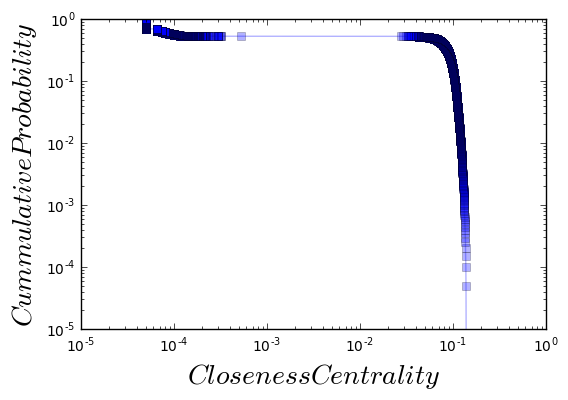

In [50]:
def cdf_plot(X):
    sorted_data = sorted(X, reverse=True)
    # yvals is not P(X)
    yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data,yvals,'bs-', alpha=0.3)
    # plt.xlim(min(sorted_data),max(sorted_data))
    plt.xlabel('$Closeness Centrality$', fontsize = 20)
    plt.ylabel('$Cummulative Probability$', fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
cdf_plot(closeness_centrality.values())

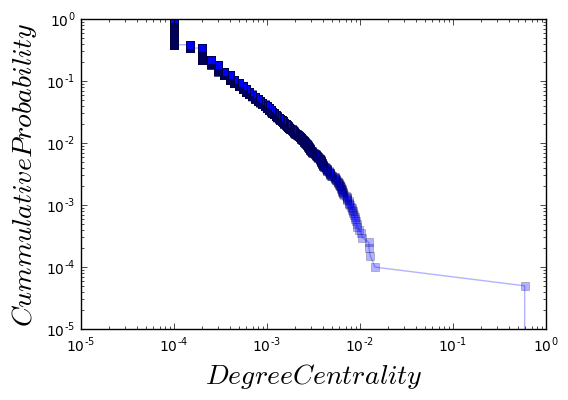

In [52]:
def cdf_plot(X):
    sorted_data = sorted(X, reverse=True)
    # yvals is not P(X)
    yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data,yvals,'bs-', alpha=0.3)
    # plt.xlim(min(sorted_data),max(sorted_data))
    plt.xlabel('$Degree Centrality$', fontsize = 20)
    plt.ylabel('$Cummulative Probability$', fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
cdf_plot(degree_centrality.values())

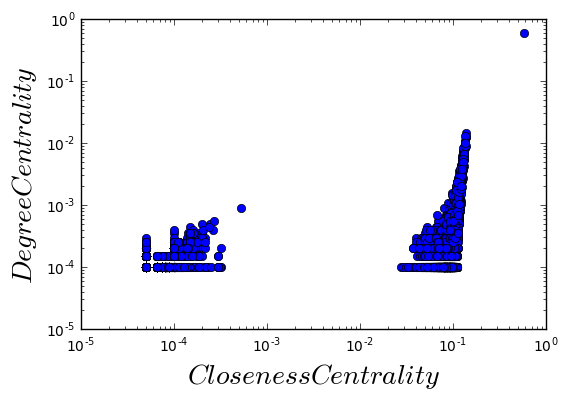

In [62]:
plt.plot(closeness_centrality.values(), degree_centrality.values(), 'o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$Closeness Centrality$', fontsize=20)
plt.ylabel('$Degree Centrality$', fontsize=20)

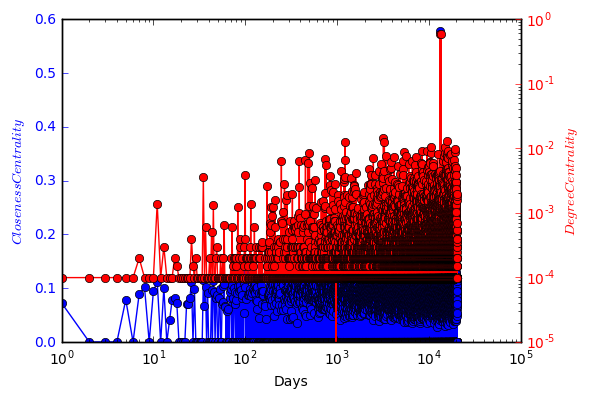

In [80]:
# plt.plot(closeness_centrality.values(), 'o')
# plt.plot(degree_centrality.values(), 'o')

fig, ax1 = plt.subplots()
ax1.plot(closeness_centrality.values(), 'b-o')
ax1.set_xlabel('Days')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('$ClosenessCentrality$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(degree_centrality.values(), 'r-o')
ax2.set_ylabel('$DegreeCentrality$', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()